In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as sg
import matplotlib.pyplot as plt
from matplotlib import patches
import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils
import os

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [ ]:
ephys_sessions = tuple(s for s in npc_lims.get_session_info(is_ephys=True, is_uploaded=True, is_annotated=True, project='DynamicRouting')) #, project='TempletonPilotSession'))

In [2]:
session = DynamicRoutingSession('668755_2023-08-30')
# session = DynamicRoutingSession('662892_2023-08-22')
# session = DynamicRoutingSession(ephys_sessions[0].session_id)

In [3]:
trials=pd.read_parquet(
            npc_lims.get_cache_path('trials',session.id,version='v0.0.173')
        )

units=pd.read_parquet(
            npc_lims.get_cache_path('units',session.id,version='v0.0.173')
        )

In [4]:
units

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,...,peak_electrode,spike_times,obs_intervals,electrodes,waveform_mean,waveform_sd,device_name,session_idx,date,subject_id
id,,,,,,,,,,,,,,,,,,,,,
1205,6952.0,1.070167,0.953704,6.405620,0.000000,0.0,0.000000,0.0,0.080,0.000211,...,983,"[56.4765710571627, 61.56022615220798, 68.06623...","[[20.233124536197174, 6516.356942959273]]","[974, 975, 976, 977, 978, 979, 980, 981, 982, ...","[[-0.72539985, -1.9843202, -0.22931997, -0.388...","[[14.695857, 14.751448, 16.154545, 15.920666, ...",18005102491,0,2023-08-30,668755
1120,24932.0,3.837947,0.898148,16.947573,0.000000,0.0,0.000000,0.0,0.005,0.000045,...,942,"[592.6579681916572, 682.3690424222419, 788.808...","[[20.233124536197174, 6516.356942959273]]","[933, 934, 935, 936, 937, 938, 939, 940, 941, ...","[[-2.5225196, -1.6988392, -2.2932003, -2.03579...","[[17.33178, 18.215193, 17.16219, 20.021017, 19...",18005102491,0,2023-08-30,668755
1121,119770.0,18.436986,1.000000,34.582790,0.007548,50.0,0.006816,30.0,0.010,0.000044,...,941,"[20.643287579810632, 20.76608649510295, 20.966...","[[20.233124536197174, 6516.356942959273]]","[933, 934, 935, 936, 937, 938, 939, 940, 941, ...","[[-0.49140015, 0.4352401, -0.22931997, 0.32760...","[[16.974583, 19.382114, 16.835058, 18.36748, 1...",18005102491,0,2023-08-30,668755
1122,8452.0,1.301072,0.916667,8.284084,0.030312,1.0,0.046552,1.0,0.055,0.000177,...,941,"[20.434789421517078, 20.701453732683895, 20.81...","[[20.233124536197174, 6516.356942959273]]","[933, 934, 935, 936, 937, 938, 939, 940, 941, ...","[[-0.86112094, 0.21059999, -0.45396012, 0.0374...","[[15.251453, 18.064718, 16.958841, 16.67087, 2...",18005102491,0,2023-08-30,668755
1123,17567.0,2.704204,1.000000,9.060415,0.084202,12.0,0.099697,9.0,0.110,0.000095,...,944,"[21.5757126768443, 21.85641019738627, 22.48190...","[[20.233124536197174, 6516.356942959273]]","[935, 936, 937, 938, 939, 940, 941, 942, 943, ...","[[-0.9219598, -1.0764002, 0.11700002, -1.76435...","[[18.588915, 20.147982, 19.887453, 17.005447, ...",18005102491,0,2023-08-30,668755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,31348.0,4.825669,1.000000,9.984127,0.002203,1.0,0.003311,1.0,0.010,0.000047,...,1373,"[21.63063965630173, 21.647772925278517, 22.480...","[[20.2797113973696, 6516.349710645383]]","[1365, 1366, 1367, 1368, 1369, 1370, 1371, 137...","[[0.42588013, -0.28548044, -0.71135956, -0.758...","[[15.8417845, 14.10053, 16.596464, 13.716279, ...",19192719021,0,2023-08-30,668755
1441,21744.0,3.347242,1.000000,4.364488,0.073278,16.0,0.056558,8.0,0.075,0.000142,...,1256,"[20.350077799723667, 20.47987731216647, 20.538...","[[20.2797113973696, 6516.349710645383]]","[1249, 1250, 1251, 1252, 1253, 1254, 1255, 125...","[[0.8002801, 0.26675993, 0.31355968, 0.6084003...","[[24.02269, 18.765137, 23.214405, 18.673218, 1...",19192719021,0,2023-08-30,668755
1442,181416.0,27.926934,1.000000,5.664638,0.005592,85.0,0.003460,35.0,0.005,0.000068,...,1266,"[20.299611322620844, 20.353444453744398, 21.05...","[[20.2797113973696, 6516.349710645383]]","[1249, 1250, 1251, 1252, 1253, 1254, 1255, 125...","[[-0.44460034, 0.26207963, -0.53352034, 0.8002...","[[22.026089, 18.899815, 24.206955, 20.279715, ...",19192719021,0,2023-08-30,668755


In [5]:
trials

,start_time,stop_time,quiescent_start_time,quiescent_stop_time,stim_start_time,stim_stop_time,response_window_start_time,response_window_stop_time,task_control_response_time,response_time,...,is_aud_nontarget,is_vis_nontarget,is_vis_context,is_aud_context,is_context_switch,is_repeat,is_opto,session_idx,date,subject_id
id,,,,,,,,,,,,,,,,,,,,,
0,1947.12351,1952.66137,1947.12351,1948.649696,1948.649696,1949.149696,1948.72472,1949.64210,1948.87482,1948.86788,...,False,False,False,True,False,False,False,0,2023-08-30,668755
1,1953.06163,1958.58302,1953.06163,1954.587709,1954.587709,1955.087709,1954.66302,1955.58049,1954.81314,1954.80429,...,False,False,False,True,False,False,False,0,2023-08-30,668755
2,1963.50374,1969.02506,1963.50374,1965.028836,1965.028836,1965.528836,1965.10505,1966.02254,1965.23854,1965.23163,...,False,False,False,True,False,False,False,0,2023-08-30,668755
3,1971.01003,1976.53136,1971.01003,1972.535609,1972.535609,1973.035609,1972.61139,1973.52884,1972.89498,1972.88404,...,False,False,False,True,False,False,False,0,2023-08-30,668755
4,1976.63146,1982.15272,1976.63146,1978.156993,1978.156993,1978.656993,1978.23278,1979.15018,1978.38300,1978.37424,...,False,False,False,True,False,False,False,0,2023-08-30,668755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,5556.38244,5561.95381,5556.38244,5557.924426,5557.924426,5558.424426,5558.00046,5558.93458,5558.20068,5558.18867,...,False,False,True,False,False,False,False,0,2023-08-30,668755
509,5567.77532,5573.34668,5567.77532,5569.340615,5569.340615,5569.841025,5569.39341,5570.31080,5569.66025,5569.65626,...,False,False,True,False,False,False,False,0,2023-08-30,668755
510,5574.01388,5579.56863,5574.01388,5575.556106,5575.556106,5576.056106,5575.63191,5576.54951,5575.74870,5575.74417,...,True,False,True,False,False,False,False,0,2023-08-30,668755


In [6]:
units.query('default_qc')['structure'].value_counts()

structure
MOs      311
MOp      306
ACAv     242
VISam    160
RSPv     147
SSp      126
ACAd     113
ccg       82
GU        73
ORBl      68
ec        50
root      39
MB        33
ORBvl     32
SCsg      31
EPd       29
MPT       29
NPC       28
RSPd      26
FRP       21
LGv       18
TTd       18
OLF       16
PIR       14
AId       11
CP        10
HPF        9
NOT        6
cing       5
PPT        4
ccs        3
dhc        2
fa         2
fp         2
SCzo       2
CTXsp      1
or         1
Name: count, dtype: int64

In [7]:
#make trial aligned 3d spike tensor
time_before = 0.5
time_after = 1.0
binsize = 0.01
trial_da = spike_utils.make_neuron_time_trials_tensor(units, trials, time_before, time_after, binsize)

In [8]:
#calculate aud vs. vis context baseline differences

vis_context_fr = trial_da.sel(trials=trials.query('is_vis_context').index,
                              time=slice(-0.2,0)).mean(dim=['trials','time'])

aud_context_fr = trial_da.sel(trials=trials.query('is_aud_context').index,
                              time=slice(-0.2,0)).mean(dim=['trials','time'])

vis_vs_aud_diff = vis_context_fr - aud_context_fr


Text(0, 0.5, 'unit count')

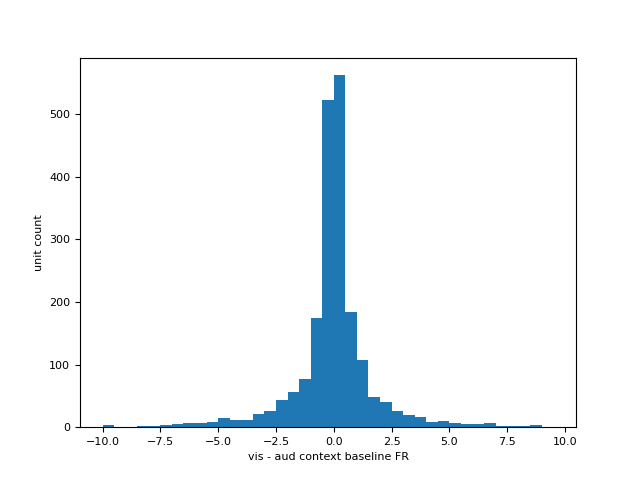

In [9]:
fig,ax=plt.subplots(1,1)
ax.hist(vis_vs_aud_diff, bins=np.arange(-10,10,0.5))
ax.set_xlabel('vis - aud context baseline FR')
ax.set_ylabel('unit count')

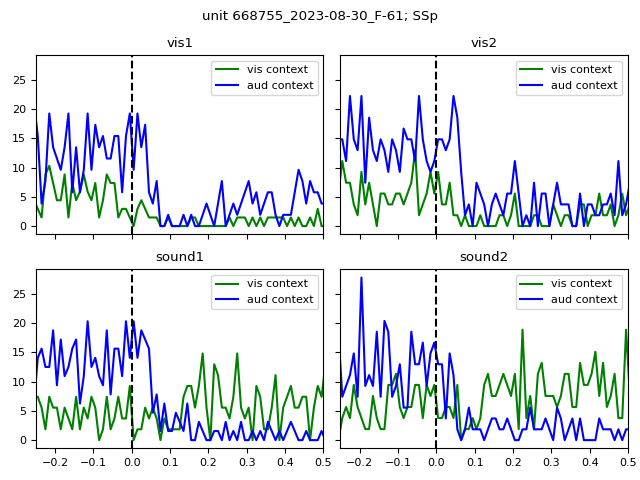

In [10]:
##plot example units with context differences -- subplot for each stimulus

sel_unit_idx=np.random.permutation(np.where(np.abs(vis_vs_aud_diff)>5)[0])[0]
# sel_unit_idx=session.units[:].query('structure.str.contains("ORB") and firing_rate>=5').index.values[5]
# sel_unit_idx=session.units[:].query('structure.str.contains("AI") and firing_rate>=4').index.values[0]

sel_unit=units['unit_id'].iloc[sel_unit_idx]

fig,ax=plt.subplots(2,2,sharex=True,sharey=True)

ax=ax.flatten()

stims=['vis1','vis2','sound1','sound2']

for st,stim in enumerate(stims):

    stim_trials=trials[:].query('stim_name==@stim')

    vis_context_spikes=trial_da.sel(
        trials=stim_trials.query('is_vis_context').index,
        unit_id=sel_unit,).mean(dim=['trials'])

    aud_context_spikes=trial_da.sel(
        trials=stim_trials.query('is_aud_context').index,
        unit_id=sel_unit,).mean(dim=['trials'])

    ax[st].plot(vis_context_spikes.time, vis_context_spikes.values, label='vis context',color='g')
    ax[st].plot(aud_context_spikes.time, aud_context_spikes.values, label='aud context',color='b')
    ax[st].axvline(0, color='k', linestyle='--')
    ax[st].set_title(stim)
    ax[st].legend()
    ax[st].set_xlim([-0.25,0.5])

fig.suptitle('unit '+units.iloc[sel_unit_idx]['unit_id']+'; '+units.iloc[sel_unit_idx]['structure'])

fig.tight_layout()

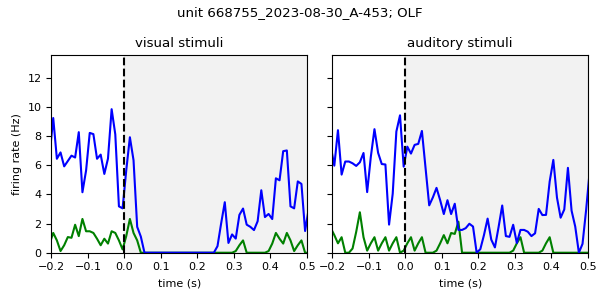

In [14]:

sel_unit_idx=np.random.permutation(np.where(np.abs(vis_vs_aud_diff)>3)[0])[0]
# sel_unit_idx=np.where((np.abs(vis_vs_aud_diff)>3)&(session.units[:]['structure'].str.contains("ACAd").values))[0][1]
# sel_unit_idx=units[:].query('unit_id == "668755_2023-08-30_C-917"').index.values[0]
# sel_unit_idx=session.units[:].query('structure.str.contains("VIS") and firing_rate>=5').index.values[0]

sel_unit=units['unit_id'][sel_unit_idx]

session_id_str=str(session.id)

# gwindow = sg.windows.gaussian(25, std=10)
gwindow = sg.windows.gaussian(5, std=1)
gwindow[3:]=0
# gwindow=np.ones(10)

fig,ax=plt.subplots(1,2,sharex=True,sharey=True,figsize=(6,3))

stims=['vis1','sound1']

rmax=[]

for st,stim in enumerate(stims):

    stim_trials=trials.query('stim_name==@stim')

    vis_context_spikes=trial_da.sel(
        trials=stim_trials.query('is_vis_context').index,
        unit_id=sel_unit,).mean(dim=['trials'])

    aud_context_spikes=trial_da.sel(
        trials=stim_trials.query('is_aud_context').index,
        unit_id=sel_unit,).mean(dim=['trials'])

    vis_spikes_smooth=sg.convolve(vis_context_spikes.values,gwindow,mode='same')/np.sum(gwindow)
    aud_spikes_smooth=sg.convolve(aud_context_spikes.values,gwindow,mode='same')/np.sum(gwindow)

    stim_rect=patches.Rectangle([0,-22],0.5,200,color='grey',alpha=0.1)
    ax[st].add_patch(stim_rect)
    ax[st].plot(vis_context_spikes.time, vis_spikes_smooth, label='vis context',color='g')
    ax[st].plot(aud_context_spikes.time, aud_spikes_smooth, label='aud context',color='b')
    ax[st].axvline(0, color='k', linestyle='--')
    # ax[st].set_title(stim)
    # ax[st].legend()
    ax[st].set_xlim(-0.2,0.5)
    ax[st].set_xlabel('time (s)')

    rmax.append(np.max([np.max(vis_spikes_smooth),np.max(aud_spikes_smooth)]))
    if st==0:
        ax[st].set_ylabel('firing rate (Hz)')
        ax[st].set_title('visual stimuli')
    elif st==1:
            ax[st].set_title('auditory stimuli')
ax[st].set_ylim(0,np.max(rmax)*1.1)
fig.suptitle('unit '+units.iloc[sel_unit_idx]['unit_id']+'; '+units.iloc[sel_unit_idx]['structure'])

fig.tight_layout()

In [ ]:
# figpath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2023-10-26-example_units_for_DR_poster'
# figname='unit_'+session.units[:].iloc[sel_unit]['unit_id']+'_'+session.units[:].iloc[sel_unit]['structure']+'_10ms_smoothing.pdf'
# # figname='control_heatmap_500ms_all.png'
# fig.savefig(os.path.join(figpath,figname), dpi=300, facecolor='w', edgecolor='w',
#             orientation='portrait', format='pdf',
#             transparent=True, bbox_inches='tight', pad_inches=0.1,
#             metadata=None)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21180\3729081923.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,1)


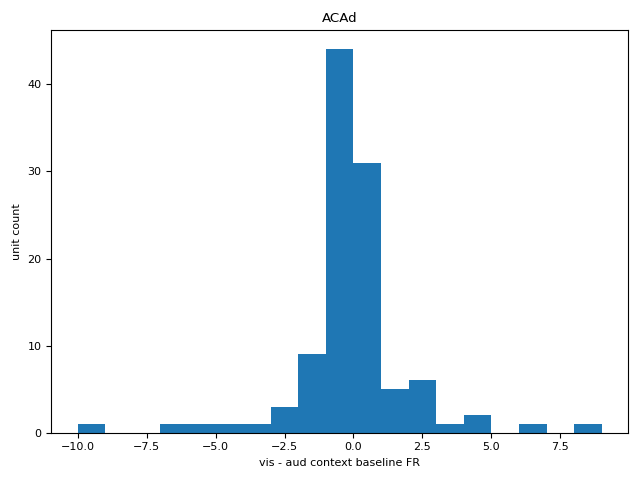

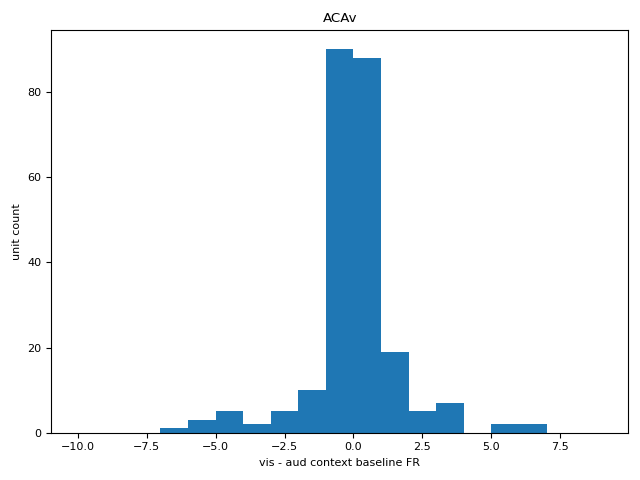

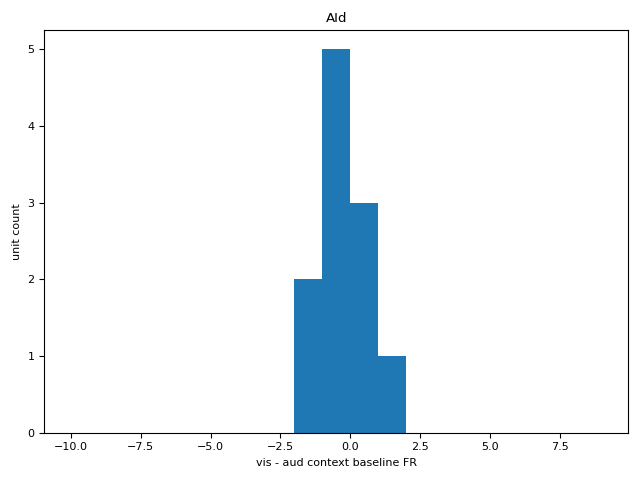

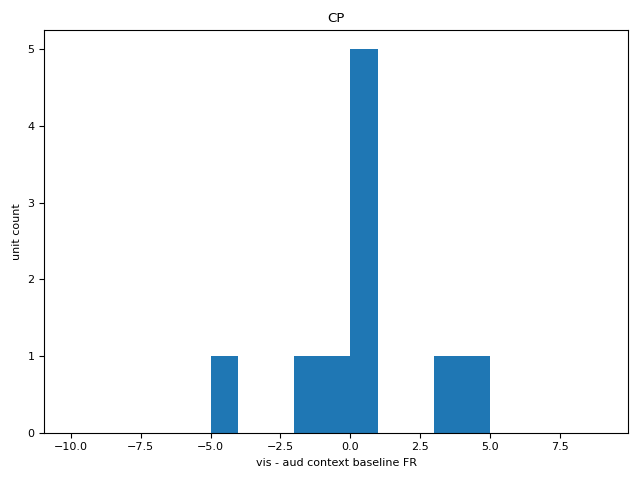

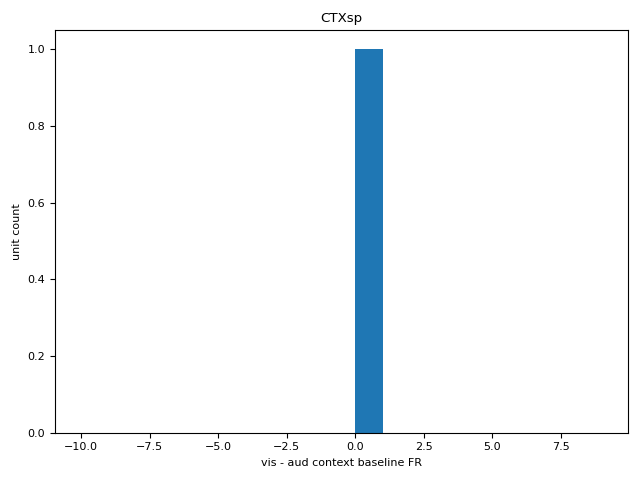

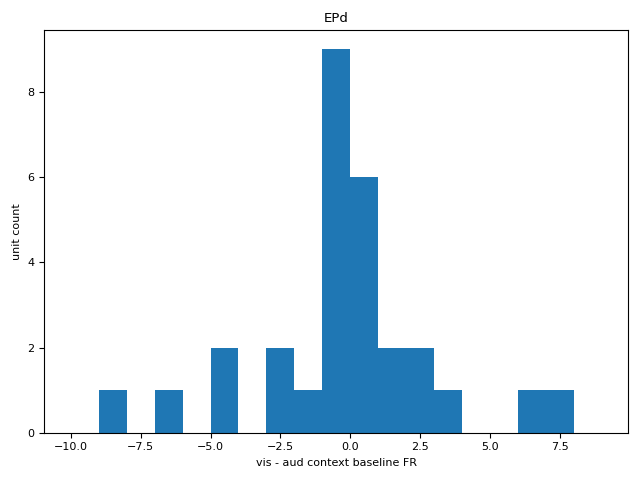

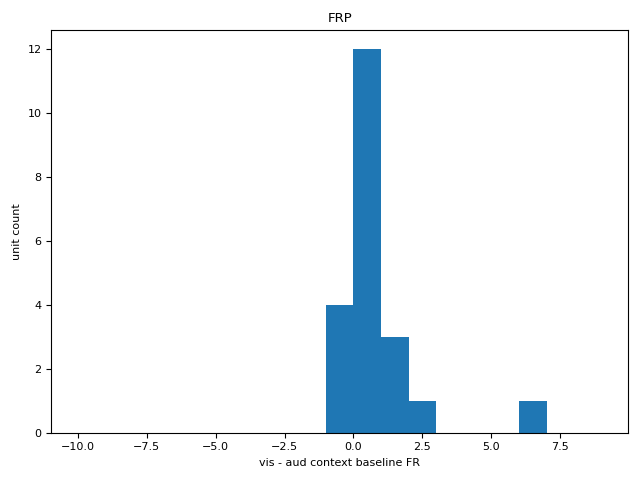

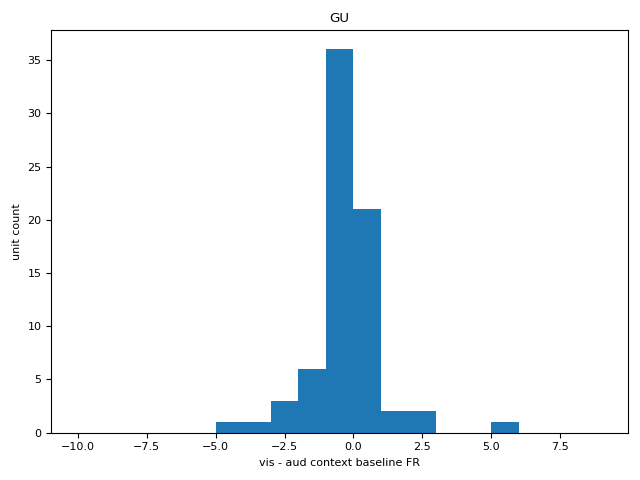

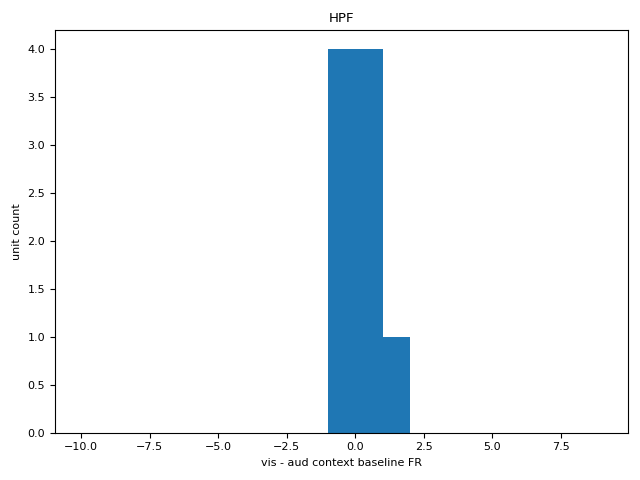

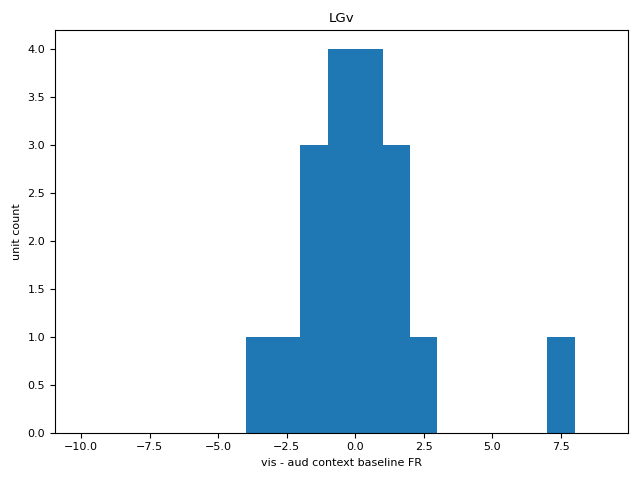

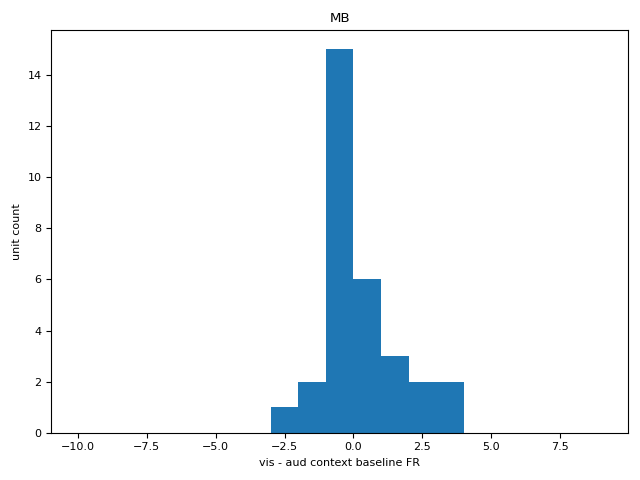

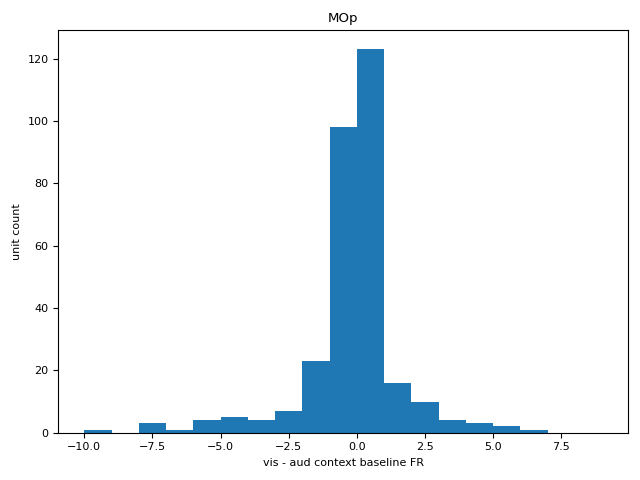

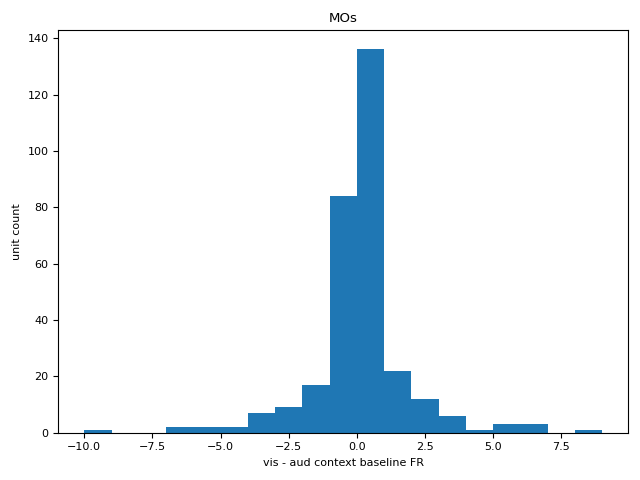

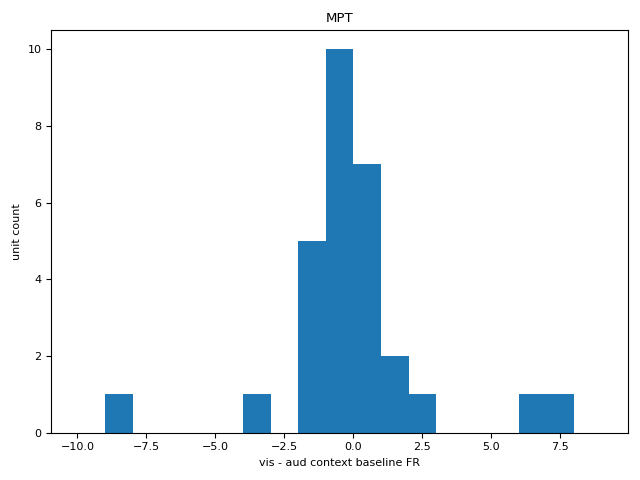

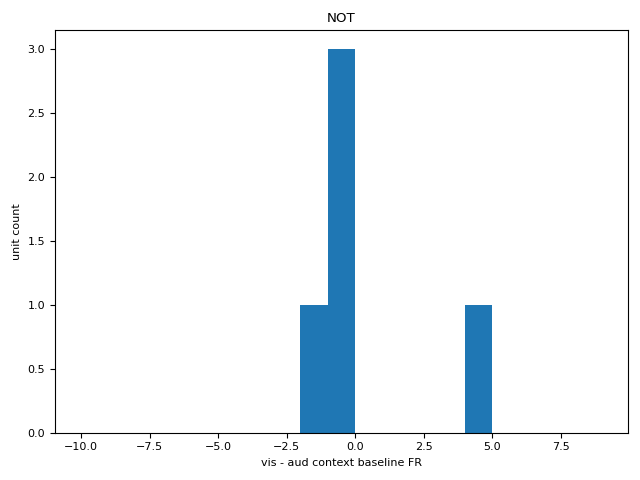

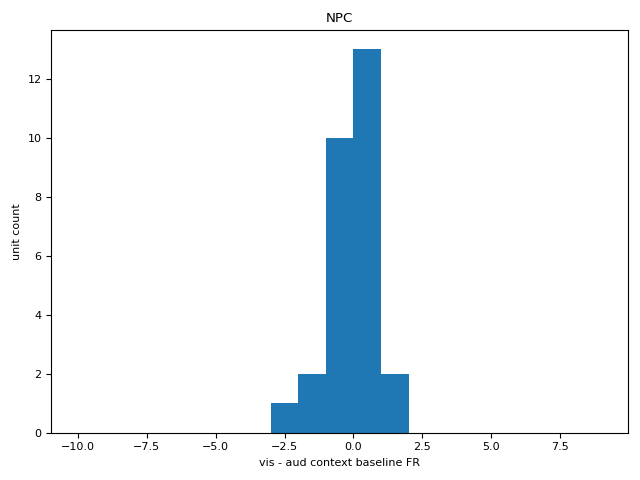

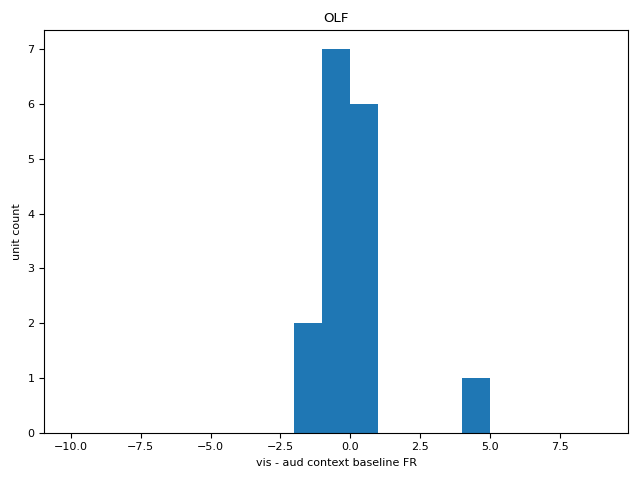

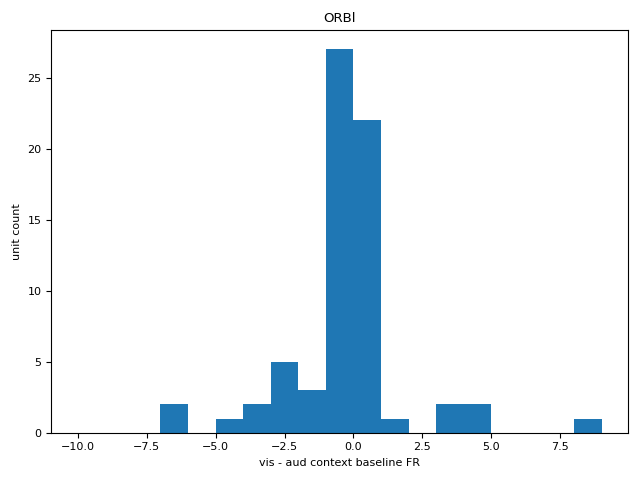

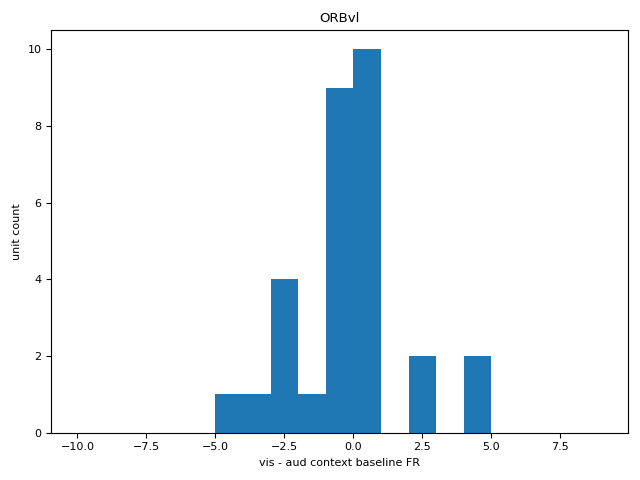

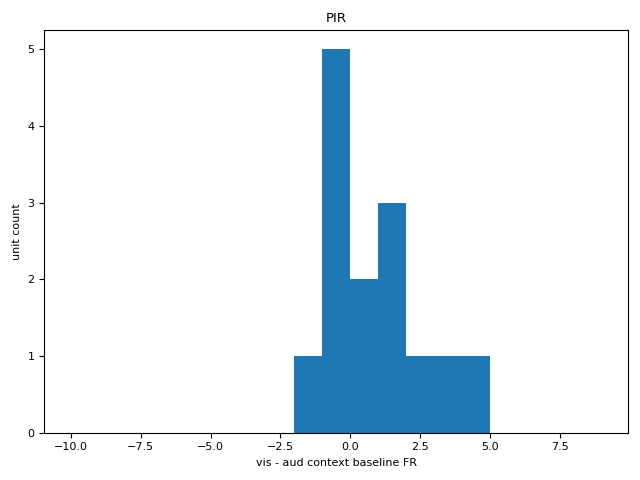

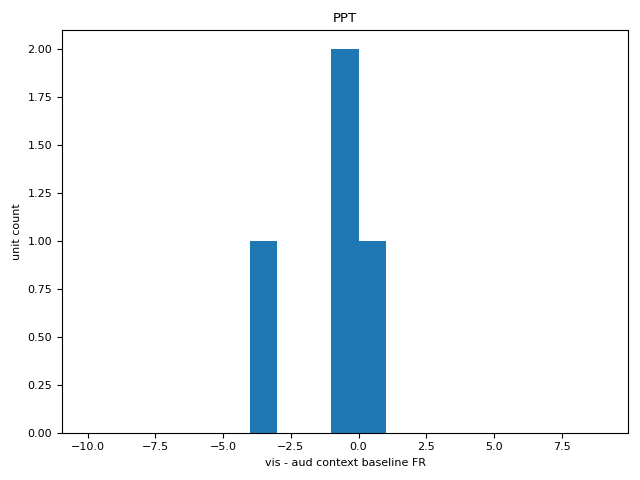

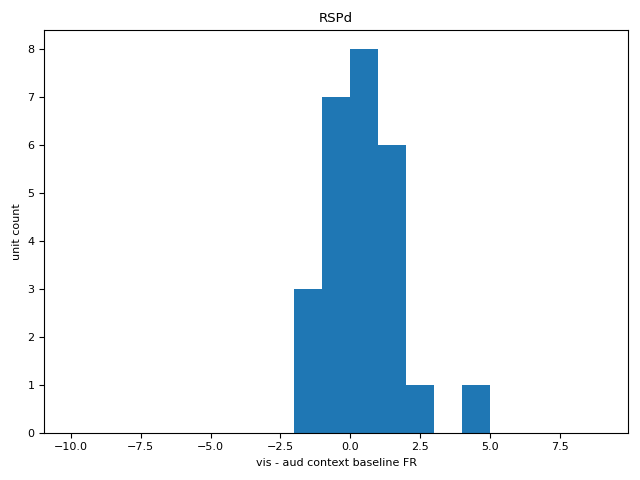

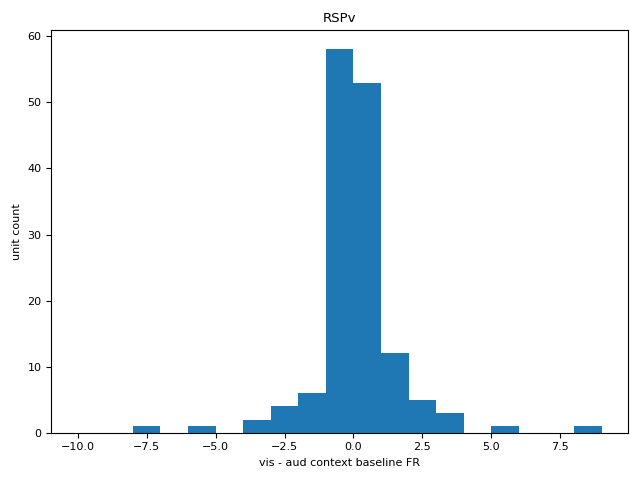

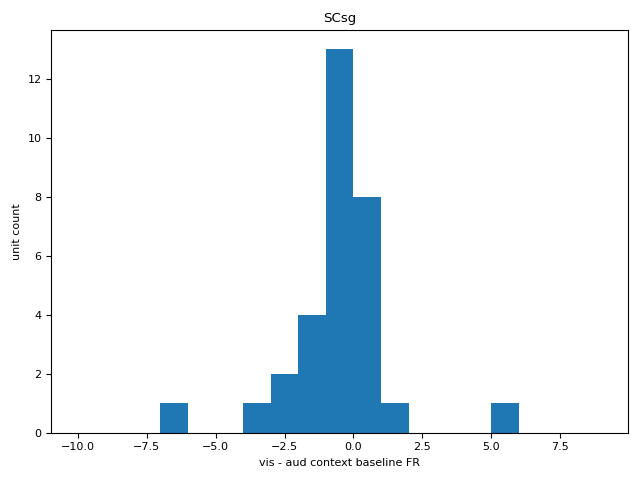

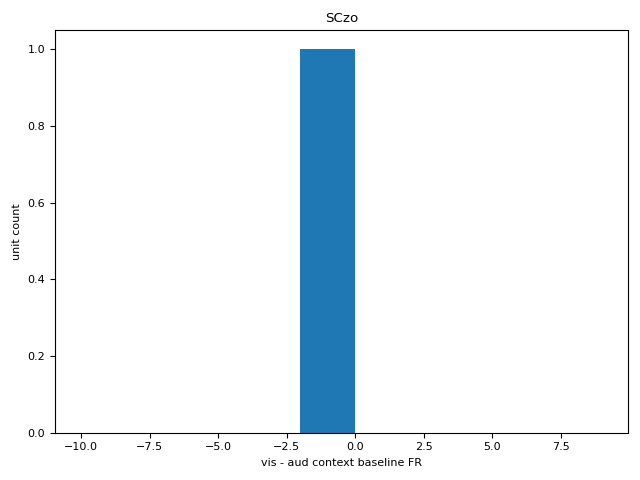

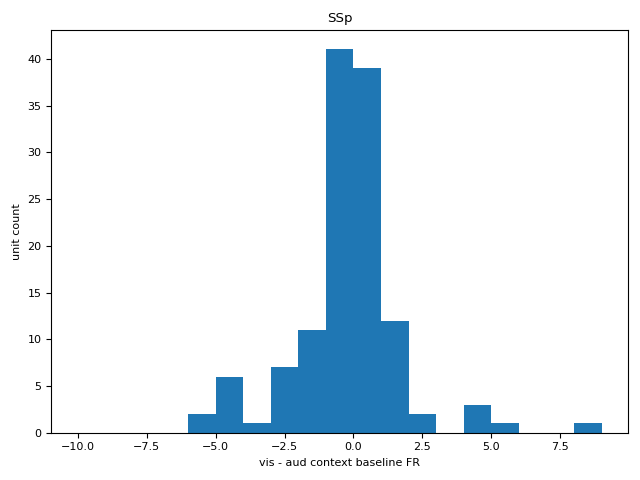

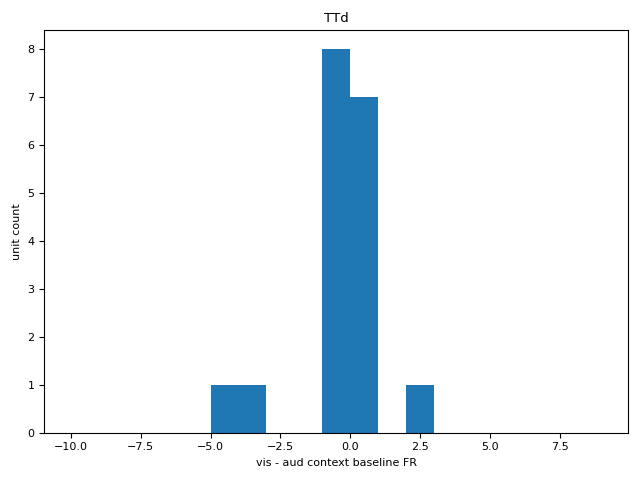

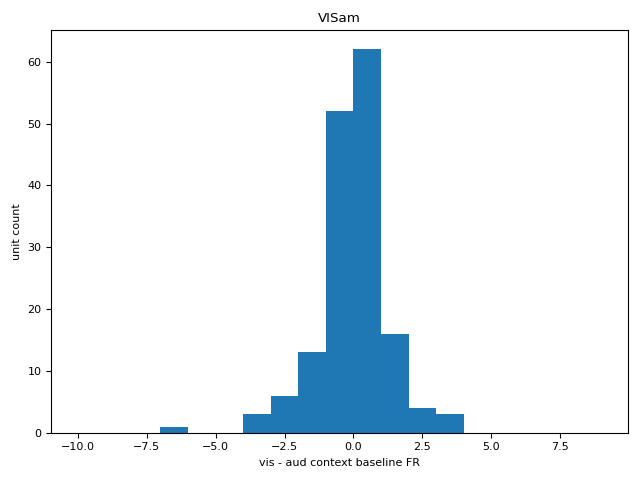

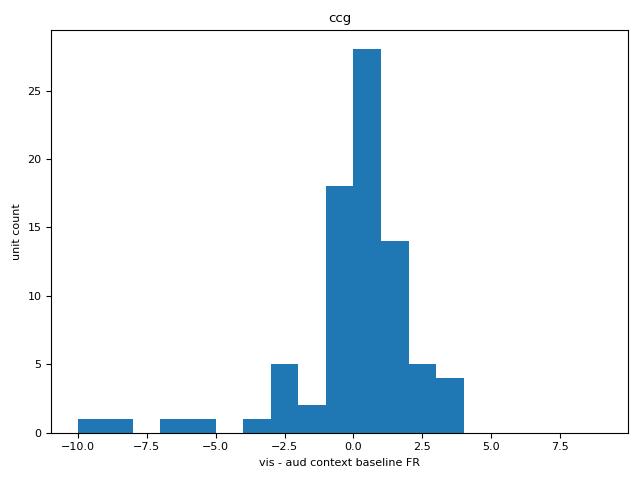

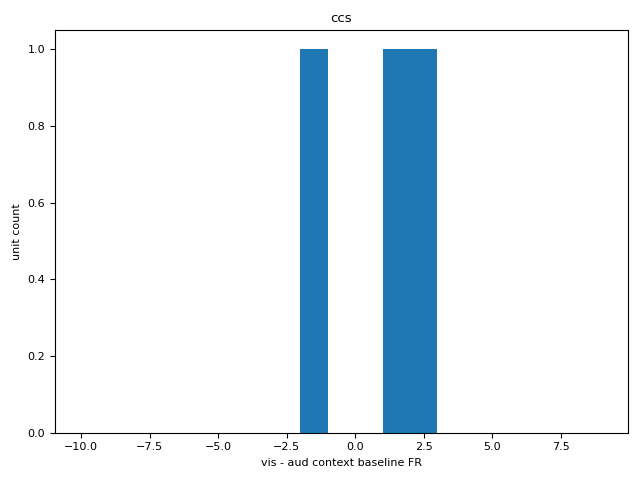

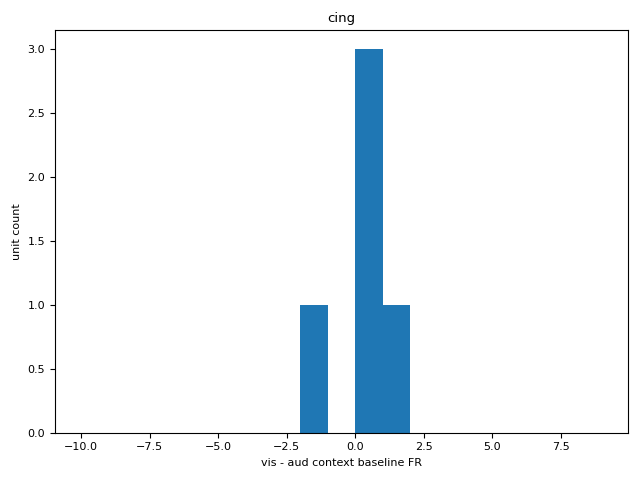

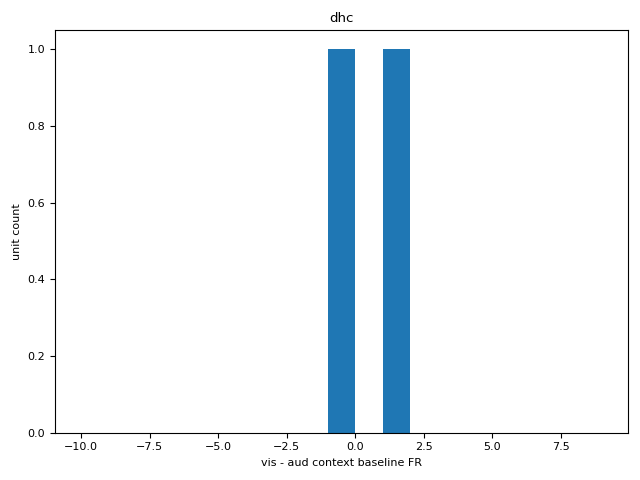

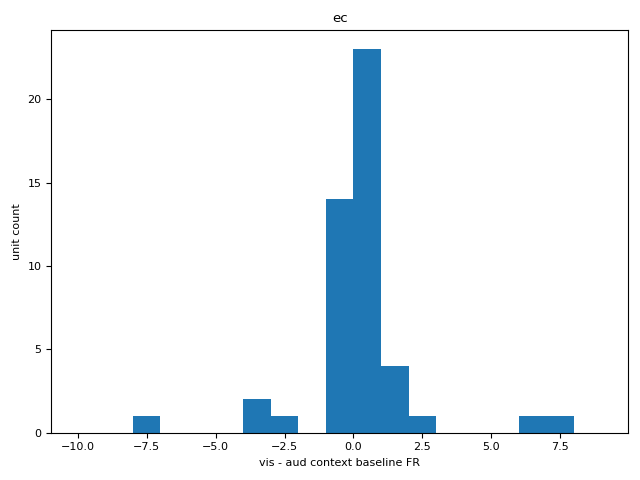

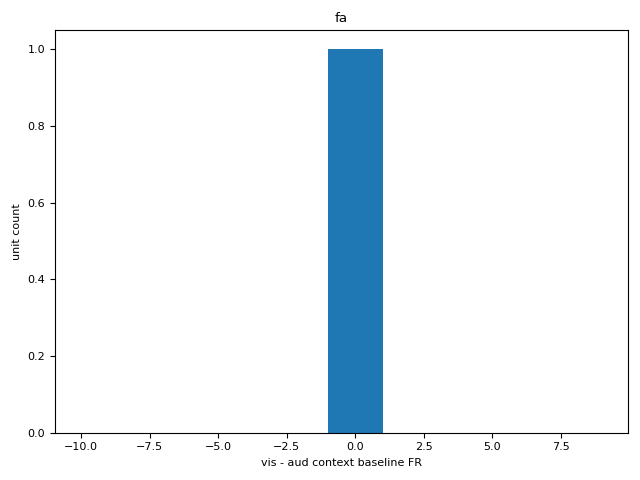

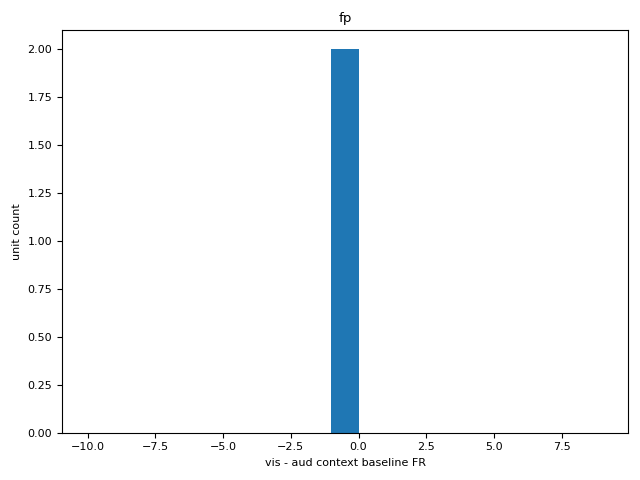

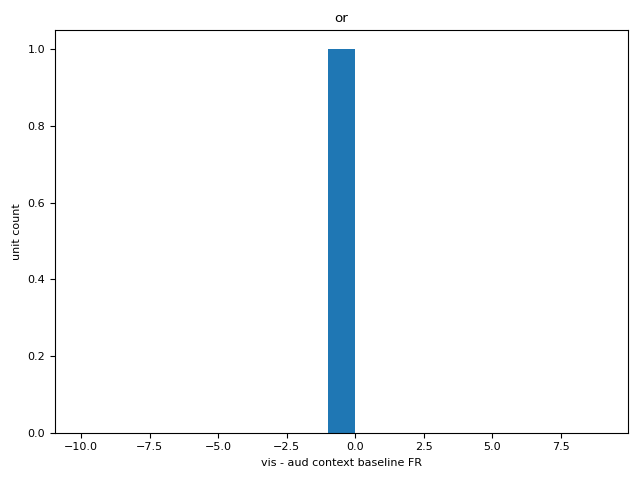

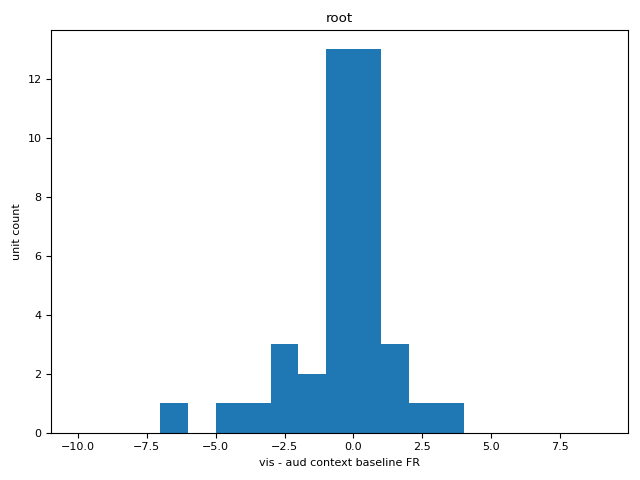

In [15]:
#plot distribution of vis vs. aud context fr differences for each area
xbins=np.arange(-10,10,1)

for area in units['structure'].unique():

    fig,ax=plt.subplots(1,1)

    area_vis_vs_aud_diff = vis_vs_aud_diff[units.query('structure==@area').index.values]

    ax.hist(area_vis_vs_aud_diff, bins=xbins)
    ax.set_xlabel('vis - aud context baseline FR')
    ax.set_ylabel('unit count')
    ax.set_title(area)

    fig.tight_layout()